In [1]:
import os
import math
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from lstm import lstm
from utils import get_data, get_state_diff_data, teacher_forcing_rate
from utils import mse_loss, wassdistance_loss, mixture_loss 
from train_and_pred import train, pred
from dataset import get_dataloader

In [32]:
data_root = './2nd_version_data'
input_dim = 21
hidden_dim = 128
output_dim = 1
unit_num = 2
batch_size = 128
device = 'cuda:0'
gtn = 10 # ground truth number
threshold = 0.2 # thresh hold for calculating accuracy
lr = 1e-3
weight_decay = 5e-4
num_epoch = 500 # total epoch
epoch_size = 5 # training epoch
tfr_decay_rate = 0.05
tfr_lower_bound = 0
loss_func = mse_loss # custom loss function
model_name = 'mse_RNN'

In [3]:
X, Y, L = get_state_diff_data(data_root)
train_loader, val_loader = get_dataloader(X, Y, L, batch_size=batch_size, device=device)
train_iterator = iter(train_loader)
val_iterator = iter(val_loader)

  0%|          | 0/630 [00:00<?, ?it/s]

training size: 123460, validation size: 30013


In [33]:
def train_model():
    global train_iterator
    
    if os.path.exists(f'./log/{model_name}.txt'):
        os.remove(f'./log/{model_name}.txt')

    model = lstm(input_dim, hidden_dim, output_dim, unit_num, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    tfr = teacher_forcing_rate(tfr_decay_rate, tfr_lower_bound)

    best_val_loss = 1e9
    for i_epoch in range(1, num_epoch+1):

        epoch_start_time = time.time()
        train_loss = 0
        train_acc = 0
        train_count = 0
        for _ in range(epoch_size):
            try:
                x, y, l = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_loader)
                x, y, l = next(train_iterator)

            loss, acc, count = train(model, optimizer, x, y, l, tfr, gtn, threshold, loss_func)
            train_loss += loss
            train_acc += acc
            train_count += count

        val_loss = 0
        val_acc = 0
        val_count = 0
        for data in val_loader:
            x, y, l = data
            loss, acc, count = pred(model, x, y, l, gtn, threshold, loss_func)
            val_loss += loss
            val_acc += acc
            val_count += count

        log_str = '[%03d/%03d] %2.2f sec(s) Train Loss: %3.4f Acc: %3.4f | Val loss: %3.4f Acc: %3.4f' % \
            (i_epoch, num_epoch, time.time()-epoch_start_time, \
             train_loss/train_count, train_acc/train_count, \
             val_loss/val_count, val_acc/val_count)

        print(log_str)
        with open(f'./log/{model_name}.txt', 'a') as train_record:
            train_record.write(log_str+"\n")

        tfr.update()

        if val_loss / val_count < best_val_loss:
            best_val_loss = val_loss / val_count
            torch.save(model.state_dict(), f'model/{model_name}.pth')

In [35]:
loss_func = mse_loss # custom loss function
model_name = 'mse_RNN'
train_model()

[001/500] 4.18 sec(s) Train Loss: 3.7875 Acc: 0.0167 | Val loss: 0.9332 Acc: 0.0949
[002/500] 4.09 sec(s) Train Loss: 0.5513 Acc: 0.2000 | Val loss: 0.7085 Acc: 0.1440
[003/500] 4.13 sec(s) Train Loss: 0.5775 Acc: 0.2041 | Val loss: 0.4314 Acc: 0.2262
[004/500] 4.17 sec(s) Train Loss: 0.4294 Acc: 0.2039 | Val loss: 0.4651 Acc: 0.3484
[005/500] 4.07 sec(s) Train Loss: 0.4390 Acc: 0.2642 | Val loss: 0.4406 Acc: 0.1960
[006/500] 4.16 sec(s) Train Loss: 0.4045 Acc: 0.2297 | Val loss: 0.4158 Acc: 0.2639
[007/500] 4.03 sec(s) Train Loss: 0.3907 Acc: 0.2120 | Val loss: 0.4316 Acc: 0.2263
[008/500] 4.08 sec(s) Train Loss: 0.4093 Acc: 0.2170 | Val loss: 0.4153 Acc: 0.2636
[009/500] 4.21 sec(s) Train Loss: 0.3898 Acc: 0.2505 | Val loss: 0.4158 Acc: 0.3085
[010/500] 4.11 sec(s) Train Loss: 0.3963 Acc: 0.2624 | Val loss: 0.4151 Acc: 0.2966
[011/500] 4.21 sec(s) Train Loss: 0.3984 Acc: 0.2360 | Val loss: 0.4165 Acc: 0.2639
[012/500] 4.19 sec(s) Train Loss: 0.3924 Acc: 0.2262 | Val loss: 0.4159 Acc:

[099/500] 4.12 sec(s) Train Loss: 0.3522 Acc: 0.2631 | Val loss: 0.3540 Acc: 0.3027
[100/500] 4.07 sec(s) Train Loss: 0.3458 Acc: 0.2839 | Val loss: 0.3648 Acc: 0.2547
[101/500] 4.06 sec(s) Train Loss: 0.3359 Acc: 0.2594 | Val loss: 0.3809 Acc: 0.2972
[102/500] 4.12 sec(s) Train Loss: 0.3207 Acc: 0.2951 | Val loss: 0.3583 Acc: 0.2563
[103/500] 4.08 sec(s) Train Loss: 0.3256 Acc: 0.2925 | Val loss: 0.3684 Acc: 0.2526
[104/500] 4.09 sec(s) Train Loss: 0.3025 Acc: 0.2772 | Val loss: 0.3534 Acc: 0.3087
[105/500] 4.14 sec(s) Train Loss: 0.3252 Acc: 0.3101 | Val loss: 0.3361 Acc: 0.2926
[106/500] 4.10 sec(s) Train Loss: 0.3040 Acc: 0.3148 | Val loss: 0.3595 Acc: 0.2831
[107/500] 4.15 sec(s) Train Loss: 0.3073 Acc: 0.3096 | Val loss: 0.3417 Acc: 0.2885
[108/500] 4.13 sec(s) Train Loss: 0.3005 Acc: 0.3139 | Val loss: 0.3539 Acc: 0.2451
[109/500] 4.08 sec(s) Train Loss: 0.3070 Acc: 0.2943 | Val loss: 0.3424 Acc: 0.2963
[110/500] 4.15 sec(s) Train Loss: 0.3079 Acc: 0.3056 | Val loss: 0.3305 Acc:

[197/500] 4.14 sec(s) Train Loss: 0.2336 Acc: 0.3756 | Val loss: 0.3742 Acc: 0.2660
[198/500] 4.30 sec(s) Train Loss: 0.2415 Acc: 0.3508 | Val loss: 0.3578 Acc: 0.2626
[199/500] 4.12 sec(s) Train Loss: 0.2327 Acc: 0.3746 | Val loss: 0.3717 Acc: 0.2718
[200/500] 4.12 sec(s) Train Loss: 0.2401 Acc: 0.3763 | Val loss: 0.3650 Acc: 0.2713
[201/500] 4.20 sec(s) Train Loss: 0.2276 Acc: 0.3607 | Val loss: 0.4049 Acc: 0.3025
[202/500] 4.12 sec(s) Train Loss: 0.2429 Acc: 0.3540 | Val loss: 0.3841 Acc: 0.2992
[203/500] 4.34 sec(s) Train Loss: 0.2244 Acc: 0.3861 | Val loss: 0.3780 Acc: 0.3111
[204/500] 4.37 sec(s) Train Loss: 0.2361 Acc: 0.3560 | Val loss: 0.3976 Acc: 0.2972
[205/500] 4.40 sec(s) Train Loss: 0.2309 Acc: 0.3711 | Val loss: 0.3277 Acc: 0.2609
[206/500] 4.10 sec(s) Train Loss: 0.2545 Acc: 0.3454 | Val loss: 0.3188 Acc: 0.3066
[207/500] 4.06 sec(s) Train Loss: 0.2393 Acc: 0.3479 | Val loss: 0.3671 Acc: 0.3184
[208/500] 4.03 sec(s) Train Loss: 0.2590 Acc: 0.3602 | Val loss: 0.4138 Acc:

[295/500] 4.01 sec(s) Train Loss: 0.2015 Acc: 0.4011 | Val loss: 0.3766 Acc: 0.2897
[296/500] 4.02 sec(s) Train Loss: 0.1974 Acc: 0.4061 | Val loss: 0.3489 Acc: 0.3002
[297/500] 4.09 sec(s) Train Loss: 0.1987 Acc: 0.4039 | Val loss: 0.3564 Acc: 0.2962
[298/500] 4.05 sec(s) Train Loss: 0.1979 Acc: 0.4044 | Val loss: 0.3449 Acc: 0.2906
[299/500] 4.11 sec(s) Train Loss: 0.1886 Acc: 0.4096 | Val loss: 0.3488 Acc: 0.2954
[300/500] 4.06 sec(s) Train Loss: 0.1925 Acc: 0.4122 | Val loss: 0.3474 Acc: 0.2964
[301/500] 4.04 sec(s) Train Loss: 0.1860 Acc: 0.4157 | Val loss: 0.3590 Acc: 0.2945
[302/500] 4.07 sec(s) Train Loss: 0.1839 Acc: 0.4228 | Val loss: 0.3555 Acc: 0.2820
[303/500] 4.02 sec(s) Train Loss: 0.1897 Acc: 0.4115 | Val loss: 0.3708 Acc: 0.2873
[304/500] 4.02 sec(s) Train Loss: 0.1965 Acc: 0.4103 | Val loss: 0.3627 Acc: 0.2815
[305/500] 4.09 sec(s) Train Loss: 0.1878 Acc: 0.3985 | Val loss: 0.3941 Acc: 0.2825
[306/500] 4.03 sec(s) Train Loss: 0.2050 Acc: 0.3875 | Val loss: 0.3930 Acc:

[393/500] 4.09 sec(s) Train Loss: 0.1845 Acc: 0.4207 | Val loss: 0.4012 Acc: 0.2742
[394/500] 4.02 sec(s) Train Loss: 0.1700 Acc: 0.4325 | Val loss: 0.4130 Acc: 0.2581
[395/500] 4.08 sec(s) Train Loss: 0.1599 Acc: 0.4507 | Val loss: 0.3952 Acc: 0.2499
[396/500] 4.02 sec(s) Train Loss: 0.1491 Acc: 0.4606 | Val loss: 0.4112 Acc: 0.2609
[397/500] 4.02 sec(s) Train Loss: 0.1468 Acc: 0.4738 | Val loss: 0.4425 Acc: 0.2469
[398/500] 4.08 sec(s) Train Loss: 0.1539 Acc: 0.4573 | Val loss: 0.3988 Acc: 0.2724
[399/500] 4.03 sec(s) Train Loss: 0.1391 Acc: 0.4825 | Val loss: 0.4248 Acc: 0.2684
[400/500] 4.04 sec(s) Train Loss: 0.1463 Acc: 0.4776 | Val loss: 0.4332 Acc: 0.2653
[401/500] 4.10 sec(s) Train Loss: 0.1481 Acc: 0.4613 | Val loss: 0.4310 Acc: 0.2603
[402/500] 4.05 sec(s) Train Loss: 0.1372 Acc: 0.4979 | Val loss: 0.4201 Acc: 0.2688
[403/500] 4.09 sec(s) Train Loss: 0.1421 Acc: 0.4732 | Val loss: 0.4351 Acc: 0.2589
[404/500] 4.02 sec(s) Train Loss: 0.1401 Acc: 0.4892 | Val loss: 0.4219 Acc:

[491/500] 4.09 sec(s) Train Loss: 0.1018 Acc: 0.5738 | Val loss: 0.4474 Acc: 0.2650
[492/500] 4.02 sec(s) Train Loss: 0.0980 Acc: 0.5855 | Val loss: 0.4464 Acc: 0.2635
[493/500] 4.04 sec(s) Train Loss: 0.0995 Acc: 0.5958 | Val loss: 0.4462 Acc: 0.2647
[494/500] 4.08 sec(s) Train Loss: 0.0970 Acc: 0.5925 | Val loss: 0.4577 Acc: 0.2444
[495/500] 4.02 sec(s) Train Loss: 0.0999 Acc: 0.5822 | Val loss: 0.4597 Acc: 0.2542
[496/500] 4.02 sec(s) Train Loss: 0.0887 Acc: 0.6069 | Val loss: 0.4520 Acc: 0.2519
[497/500] 4.10 sec(s) Train Loss: 0.0976 Acc: 0.5889 | Val loss: 0.4649 Acc: 0.2604
[498/500] 4.02 sec(s) Train Loss: 0.0934 Acc: 0.5992 | Val loss: 0.4587 Acc: 0.2687
[499/500] 4.07 sec(s) Train Loss: 0.0950 Acc: 0.5889 | Val loss: 0.4487 Acc: 0.2712
[500/500] 4.03 sec(s) Train Loss: 0.0910 Acc: 0.5957 | Val loss: 0.4567 Acc: 0.2476


In [36]:
loss_func = wassdistance_loss # custom loss function
model_name = 'wass_RNN'
train_model()

[001/500] 18.07 sec(s) Train Loss: 3.9096 Acc: 0.0056 | Val loss: 1.3203 Acc: 0.0477
[002/500] 15.68 sec(s) Train Loss: 0.7346 Acc: 0.1886 | Val loss: 0.7541 Acc: 0.1439
[003/500] 14.89 sec(s) Train Loss: 0.6597 Acc: 0.2035 | Val loss: 0.5075 Acc: 0.2470
[004/500] 14.21 sec(s) Train Loss: 0.4396 Acc: 0.2342 | Val loss: 0.4845 Acc: 0.1959
[005/500] 13.23 sec(s) Train Loss: 0.4843 Acc: 0.2414 | Val loss: 0.4937 Acc: 0.1960
[006/500] 13.22 sec(s) Train Loss: 0.4508 Acc: 0.1960 | Val loss: 0.4554 Acc: 0.3001
[007/500] 13.79 sec(s) Train Loss: 0.4323 Acc: 0.2416 | Val loss: 0.4698 Acc: 0.2262
[008/500] 13.59 sec(s) Train Loss: 0.4505 Acc: 0.2087 | Val loss: 0.4674 Acc: 0.2263
[009/500] 13.71 sec(s) Train Loss: 0.4361 Acc: 0.2232 | Val loss: 0.4554 Acc: 0.3026
[010/500] 13.99 sec(s) Train Loss: 0.4325 Acc: 0.2704 | Val loss: 0.4568 Acc: 0.3075
[011/500] 14.13 sec(s) Train Loss: 0.4486 Acc: 0.2506 | Val loss: 0.4526 Acc: 0.2997
[012/500] 14.65 sec(s) Train Loss: 0.4126 Acc: 0.2471 | Val loss:

[098/500] 24.67 sec(s) Train Loss: 0.2956 Acc: 0.3260 | Val loss: 0.3893 Acc: 0.2675
[099/500] 25.94 sec(s) Train Loss: 0.2963 Acc: 0.3135 | Val loss: 0.4018 Acc: 0.2860
[100/500] 25.76 sec(s) Train Loss: 0.3038 Acc: 0.3041 | Val loss: 0.3972 Acc: 0.2667
[101/500] 24.30 sec(s) Train Loss: 0.2890 Acc: 0.3312 | Val loss: 0.3848 Acc: 0.2880
[102/500] 25.83 sec(s) Train Loss: 0.2882 Acc: 0.3288 | Val loss: 0.3906 Acc: 0.2744
[103/500] 25.45 sec(s) Train Loss: 0.3008 Acc: 0.3251 | Val loss: 0.3874 Acc: 0.2804
[104/500] 23.83 sec(s) Train Loss: 0.2755 Acc: 0.3310 | Val loss: 0.3902 Acc: 0.2855
[105/500] 26.01 sec(s) Train Loss: 0.2958 Acc: 0.3193 | Val loss: 0.4141 Acc: 0.2872
[106/500] 25.78 sec(s) Train Loss: 0.2903 Acc: 0.3185 | Val loss: 0.3945 Acc: 0.2651
[107/500] 23.03 sec(s) Train Loss: 0.3147 Acc: 0.3054 | Val loss: 0.3809 Acc: 0.2864
[108/500] 26.67 sec(s) Train Loss: 0.2860 Acc: 0.3229 | Val loss: 0.3901 Acc: 0.2676
[109/500] 24.92 sec(s) Train Loss: 0.2945 Acc: 0.3234 | Val loss:

[195/500] 26.49 sec(s) Train Loss: 0.2662 Acc: 0.3403 | Val loss: 0.4003 Acc: 0.2901
[196/500] 26.92 sec(s) Train Loss: 0.2471 Acc: 0.3499 | Val loss: 0.4058 Acc: 0.2674
[197/500] 25.99 sec(s) Train Loss: 0.2894 Acc: 0.3326 | Val loss: 0.4273 Acc: 0.2420
[198/500] 25.57 sec(s) Train Loss: 0.2850 Acc: 0.3205 | Val loss: 0.3918 Acc: 0.2852
[199/500] 25.89 sec(s) Train Loss: 0.2617 Acc: 0.3380 | Val loss: 0.4188 Acc: 0.2922
[200/500] 24.54 sec(s) Train Loss: 0.2822 Acc: 0.3201 | Val loss: 0.3864 Acc: 0.3244
[201/500] 25.71 sec(s) Train Loss: 0.2762 Acc: 0.3466 | Val loss: 0.4219 Acc: 0.2356
[202/500] 25.80 sec(s) Train Loss: 0.2890 Acc: 0.3131 | Val loss: 0.3955 Acc: 0.2939
[203/500] 24.06 sec(s) Train Loss: 0.2666 Acc: 0.3484 | Val loss: 0.4146 Acc: 0.3133
[204/500] 27.50 sec(s) Train Loss: 0.2582 Acc: 0.3525 | Val loss: 0.4032 Acc: 0.2481
[205/500] 25.59 sec(s) Train Loss: 0.2657 Acc: 0.3428 | Val loss: 0.4112 Acc: 0.2970
[206/500] 25.80 sec(s) Train Loss: 0.2684 Acc: 0.3372 | Val loss:

[292/500] 26.20 sec(s) Train Loss: 0.2290 Acc: 0.3496 | Val loss: 0.4330 Acc: 0.2736
[293/500] 27.83 sec(s) Train Loss: 0.2267 Acc: 0.3510 | Val loss: 0.4172 Acc: 0.2592
[294/500] 27.17 sec(s) Train Loss: 0.2373 Acc: 0.3411 | Val loss: 0.3824 Acc: 0.2889
[295/500] 25.46 sec(s) Train Loss: 0.2222 Acc: 0.3682 | Val loss: 0.3938 Acc: 0.2598
[296/500] 29.70 sec(s) Train Loss: 0.2208 Acc: 0.3489 | Val loss: 0.4014 Acc: 0.2399
[297/500] 25.63 sec(s) Train Loss: 0.2206 Acc: 0.3577 | Val loss: 0.4068 Acc: 0.2798
[298/500] 26.66 sec(s) Train Loss: 0.2170 Acc: 0.3608 | Val loss: 0.4092 Acc: 0.2679
[299/500] 26.90 sec(s) Train Loss: 0.2193 Acc: 0.3655 | Val loss: 0.4355 Acc: 0.2610
[300/500] 28.08 sec(s) Train Loss: 0.2316 Acc: 0.3466 | Val loss: 0.3937 Acc: 0.2746
[301/500] 25.83 sec(s) Train Loss: 0.2204 Acc: 0.3584 | Val loss: 0.4141 Acc: 0.2633
[302/500] 28.71 sec(s) Train Loss: 0.2162 Acc: 0.3570 | Val loss: 0.4094 Acc: 0.2546
[303/500] 27.04 sec(s) Train Loss: 0.2164 Acc: 0.3739 | Val loss:

[389/500] 26.79 sec(s) Train Loss: 0.1997 Acc: 0.3860 | Val loss: 0.4472 Acc: 0.2748
[390/500] 28.46 sec(s) Train Loss: 0.2014 Acc: 0.3686 | Val loss: 0.4735 Acc: 0.2887
[391/500] 26.82 sec(s) Train Loss: 0.2333 Acc: 0.3482 | Val loss: 0.4378 Acc: 0.2783
[392/500] 26.86 sec(s) Train Loss: 0.2149 Acc: 0.3681 | Val loss: 0.4055 Acc: 0.2641
[393/500] 27.40 sec(s) Train Loss: 0.2120 Acc: 0.3624 | Val loss: 0.4201 Acc: 0.2596
[394/500] 27.84 sec(s) Train Loss: 0.1989 Acc: 0.3736 | Val loss: 0.4288 Acc: 0.2771
[395/500] 25.90 sec(s) Train Loss: 0.2057 Acc: 0.3797 | Val loss: 0.4436 Acc: 0.2807
[396/500] 29.99 sec(s) Train Loss: 0.1992 Acc: 0.3764 | Val loss: 0.4424 Acc: 0.2636
[397/500] 26.89 sec(s) Train Loss: 0.2024 Acc: 0.3754 | Val loss: 0.4423 Acc: 0.2801
[398/500] 28.85 sec(s) Train Loss: 0.1985 Acc: 0.3748 | Val loss: 0.4454 Acc: 0.2826
[399/500] 29.24 sec(s) Train Loss: 0.2055 Acc: 0.3747 | Val loss: 0.4350 Acc: 0.2744
[400/500] 27.22 sec(s) Train Loss: 0.1985 Acc: 0.3842 | Val loss:

[486/500] 26.51 sec(s) Train Loss: 0.1812 Acc: 0.4041 | Val loss: 0.4572 Acc: 0.2712
[487/500] 27.37 sec(s) Train Loss: 0.1924 Acc: 0.3834 | Val loss: 0.4464 Acc: 0.2815
[488/500] 29.01 sec(s) Train Loss: 0.1790 Acc: 0.3978 | Val loss: 0.4554 Acc: 0.2970
[489/500] 25.65 sec(s) Train Loss: 0.1776 Acc: 0.4057 | Val loss: 0.4638 Acc: 0.2678
[490/500] 28.24 sec(s) Train Loss: 0.1816 Acc: 0.3926 | Val loss: 0.4456 Acc: 0.2716
[491/500] 29.37 sec(s) Train Loss: 0.1770 Acc: 0.3995 | Val loss: 0.4705 Acc: 0.2747
[492/500] 24.73 sec(s) Train Loss: 0.1726 Acc: 0.4091 | Val loss: 0.4795 Acc: 0.2680
[493/500] 27.15 sec(s) Train Loss: 0.1770 Acc: 0.4114 | Val loss: 0.4839 Acc: 0.2649
[494/500] 27.45 sec(s) Train Loss: 0.1735 Acc: 0.4074 | Val loss: 0.4885 Acc: 0.2783
[495/500] 26.45 sec(s) Train Loss: 0.1898 Acc: 0.4028 | Val loss: 0.4792 Acc: 0.2704
[496/500] 27.16 sec(s) Train Loss: 0.1731 Acc: 0.4164 | Val loss: 0.4630 Acc: 0.2718
[497/500] 26.89 sec(s) Train Loss: 0.1767 Acc: 0.4092 | Val loss:

In [37]:
loss_func = mixture_loss # custom loss function
model_name = 'mix_RNN'
train_model()

[001/500] 17.47 sec(s) Train Loss: 7.8587 Acc: 0.0110 | Val loss: 2.1971 Acc: 0.0814
[002/500] 16.08 sec(s) Train Loss: 1.3136 Acc: 0.1730 | Val loss: 1.5142 Acc: 0.1450
[003/500] 13.82 sec(s) Train Loss: 1.1838 Acc: 0.2094 | Val loss: 0.9141 Acc: 0.2260
[004/500] 14.38 sec(s) Train Loss: 0.8835 Acc: 0.1982 | Val loss: 0.9470 Acc: 0.1980
[005/500] 13.42 sec(s) Train Loss: 0.8935 Acc: 0.1858 | Val loss: 0.9119 Acc: 0.1965
[006/500] 14.26 sec(s) Train Loss: 0.8089 Acc: 0.2408 | Val loss: 0.8735 Acc: 0.2630
[007/500] 14.32 sec(s) Train Loss: 0.9039 Acc: 0.2059 | Val loss: 0.8893 Acc: 0.2288
[008/500] 13.65 sec(s) Train Loss: 0.7617 Acc: 0.2313 | Val loss: 0.8715 Acc: 0.2641
[009/500] 14.09 sec(s) Train Loss: 0.8637 Acc: 0.2331 | Val loss: 0.8647 Acc: 0.2839
[010/500] 14.21 sec(s) Train Loss: 0.8085 Acc: 0.2572 | Val loss: 0.8668 Acc: 0.2642
[011/500] 14.08 sec(s) Train Loss: 0.8216 Acc: 0.2234 | Val loss: 0.8638 Acc: 0.2644
[012/500] 14.35 sec(s) Train Loss: 0.8233 Acc: 0.2318 | Val loss:

[098/500] 24.58 sec(s) Train Loss: 0.5198 Acc: 0.3477 | Val loss: 0.6912 Acc: 0.2872
[099/500] 25.01 sec(s) Train Loss: 0.5577 Acc: 0.3364 | Val loss: 0.7041 Acc: 0.2748
[100/500] 23.87 sec(s) Train Loss: 0.5428 Acc: 0.3419 | Val loss: 0.7226 Acc: 0.2805
[101/500] 24.68 sec(s) Train Loss: 0.5256 Acc: 0.3414 | Val loss: 0.7253 Acc: 0.2816
[102/500] 26.64 sec(s) Train Loss: 0.5300 Acc: 0.3490 | Val loss: 0.6977 Acc: 0.2862
[103/500] 23.49 sec(s) Train Loss: 0.4967 Acc: 0.3715 | Val loss: 0.7013 Acc: 0.2944
[104/500] 23.91 sec(s) Train Loss: 0.5672 Acc: 0.3408 | Val loss: 0.7163 Acc: 0.2615
[105/500] 24.61 sec(s) Train Loss: 0.5586 Acc: 0.3368 | Val loss: 0.8188 Acc: 0.2037
[106/500] 22.88 sec(s) Train Loss: 0.6242 Acc: 0.3174 | Val loss: 0.8273 Acc: 0.3217
[107/500] 22.47 sec(s) Train Loss: 0.6021 Acc: 0.2977 | Val loss: 0.7431 Acc: 0.2969
[108/500] 23.05 sec(s) Train Loss: 0.5826 Acc: 0.3192 | Val loss: 0.7615 Acc: 0.2418
[109/500] 24.47 sec(s) Train Loss: 0.5562 Acc: 0.3399 | Val loss:

[195/500] 25.90 sec(s) Train Loss: 0.3846 Acc: 0.4249 | Val loss: 0.7815 Acc: 0.2143
[196/500] 27.53 sec(s) Train Loss: 0.4130 Acc: 0.3909 | Val loss: 0.6672 Acc: 0.2814
[197/500] 27.87 sec(s) Train Loss: 0.3936 Acc: 0.4064 | Val loss: 0.6446 Acc: 0.2664
[198/500] 27.22 sec(s) Train Loss: 0.3846 Acc: 0.4153 | Val loss: 0.6891 Acc: 0.2453
[199/500] 27.48 sec(s) Train Loss: 0.3929 Acc: 0.4037 | Val loss: 0.7195 Acc: 0.2808
[200/500] 27.78 sec(s) Train Loss: 0.3806 Acc: 0.4122 | Val loss: 0.6882 Acc: 0.2689
[201/500] 28.21 sec(s) Train Loss: 0.3733 Acc: 0.4383 | Val loss: 0.6819 Acc: 0.2378
[202/500] 30.05 sec(s) Train Loss: 0.3664 Acc: 0.4226 | Val loss: 0.7228 Acc: 0.2214
[203/500] 26.62 sec(s) Train Loss: 0.3737 Acc: 0.4200 | Val loss: 0.7135 Acc: 0.2510
[204/500] 29.16 sec(s) Train Loss: 0.3966 Acc: 0.4094 | Val loss: 0.7335 Acc: 0.2181
[205/500] 27.52 sec(s) Train Loss: 0.3880 Acc: 0.4226 | Val loss: 0.6984 Acc: 0.2455
[206/500] 27.86 sec(s) Train Loss: 0.3811 Acc: 0.4198 | Val loss:

[292/500] 28.50 sec(s) Train Loss: 0.3267 Acc: 0.4586 | Val loss: 0.7685 Acc: 0.2655
[293/500] 28.24 sec(s) Train Loss: 0.3015 Acc: 0.4695 | Val loss: 0.7315 Acc: 0.2601
[294/500] 27.90 sec(s) Train Loss: 0.3105 Acc: 0.4745 | Val loss: 0.8047 Acc: 0.2416
[295/500] 28.79 sec(s) Train Loss: 0.2841 Acc: 0.4973 | Val loss: 0.7962 Acc: 0.2316
[296/500] 29.84 sec(s) Train Loss: 0.2716 Acc: 0.5068 | Val loss: 0.7429 Acc: 0.2535
[297/500] 26.62 sec(s) Train Loss: 0.3495 Acc: 0.4550 | Val loss: 0.7257 Acc: 0.2696
[298/500] 28.34 sec(s) Train Loss: 0.3532 Acc: 0.4471 | Val loss: 0.7144 Acc: 0.2610
[299/500] 28.58 sec(s) Train Loss: 0.3521 Acc: 0.4317 | Val loss: 0.7024 Acc: 0.2637
[300/500] 27.26 sec(s) Train Loss: 0.3382 Acc: 0.4530 | Val loss: 0.7191 Acc: 0.2783
[301/500] 29.26 sec(s) Train Loss: 0.3580 Acc: 0.4247 | Val loss: 0.7584 Acc: 0.2996
[302/500] 27.22 sec(s) Train Loss: 0.3987 Acc: 0.3818 | Val loss: 0.8066 Acc: 0.3071
[303/500] 30.39 sec(s) Train Loss: 0.3681 Acc: 0.4306 | Val loss:

[389/500] 29.36 sec(s) Train Loss: 0.2594 Acc: 0.5059 | Val loss: 0.7285 Acc: 0.2537
[390/500] 30.61 sec(s) Train Loss: 0.2619 Acc: 0.5076 | Val loss: 0.7620 Acc: 0.2441
[391/500] 29.82 sec(s) Train Loss: 0.2560 Acc: 0.5253 | Val loss: 0.7656 Acc: 0.2352
[392/500] 33.81 sec(s) Train Loss: 0.2603 Acc: 0.5105 | Val loss: 0.7540 Acc: 0.2475
[393/500] 30.07 sec(s) Train Loss: 0.2560 Acc: 0.5221 | Val loss: 0.7591 Acc: 0.2600
[394/500] 29.61 sec(s) Train Loss: 0.2597 Acc: 0.5106 | Val loss: 0.7612 Acc: 0.2281
[395/500] 31.44 sec(s) Train Loss: 0.2637 Acc: 0.5141 | Val loss: 0.7739 Acc: 0.2356
[396/500] 32.75 sec(s) Train Loss: 0.2619 Acc: 0.5025 | Val loss: 0.7660 Acc: 0.2392
[397/500] 29.93 sec(s) Train Loss: 0.2484 Acc: 0.5347 | Val loss: 0.7752 Acc: 0.2294
[398/500] 32.37 sec(s) Train Loss: 0.2550 Acc: 0.5304 | Val loss: 0.7780 Acc: 0.2417
[399/500] 32.24 sec(s) Train Loss: 0.2705 Acc: 0.5014 | Val loss: 0.7751 Acc: 0.2354
[400/500] 32.09 sec(s) Train Loss: 0.2548 Acc: 0.5277 | Val loss:

[486/500] 26.92 sec(s) Train Loss: 0.2582 Acc: 0.5199 | Val loss: 0.8461 Acc: 0.2204
[487/500] 28.31 sec(s) Train Loss: 0.2668 Acc: 0.5022 | Val loss: 0.8277 Acc: 0.2425
[488/500] 28.20 sec(s) Train Loss: 0.2598 Acc: 0.5211 | Val loss: 0.8615 Acc: 0.2422
[489/500] 27.37 sec(s) Train Loss: 0.2641 Acc: 0.5065 | Val loss: 0.8932 Acc: 0.2474
[490/500] 28.63 sec(s) Train Loss: 0.2918 Acc: 0.4726 | Val loss: 0.8175 Acc: 0.2511
[491/500] 26.60 sec(s) Train Loss: 0.2994 Acc: 0.4725 | Val loss: 0.8699 Acc: 0.2440
[492/500] 26.33 sec(s) Train Loss: 0.2837 Acc: 0.4834 | Val loss: 0.7424 Acc: 0.2773
[493/500] 28.06 sec(s) Train Loss: 0.2965 Acc: 0.4804 | Val loss: 0.7922 Acc: 0.2441
[494/500] 27.56 sec(s) Train Loss: 0.2850 Acc: 0.4812 | Val loss: 0.8715 Acc: 0.2498
[495/500] 28.51 sec(s) Train Loss: 0.3013 Acc: 0.4487 | Val loss: 0.8343 Acc: 0.2473
[496/500] 26.45 sec(s) Train Loss: 0.3000 Acc: 0.4631 | Val loss: 0.7610 Acc: 0.2694
[497/500] 25.50 sec(s) Train Loss: 0.2879 Acc: 0.4798 | Val loss:

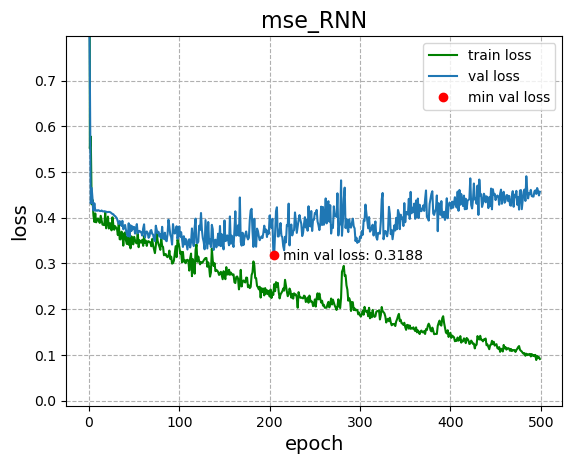

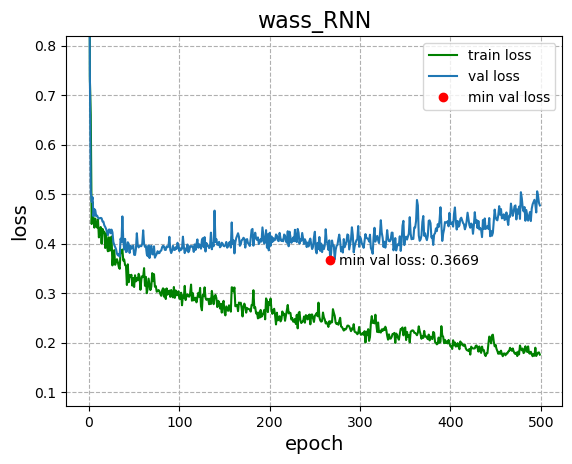

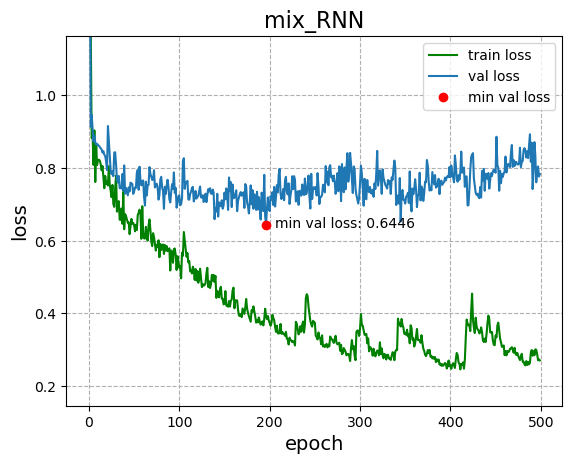

In [102]:
model_names = ['mse_RNN', 'wass_RNN', 'mix_RNN']
for model_name in model_names:
    f = open(f'./log/{model_name}.txt', 'r')
    train_loss_list = list()
    val_loss_list = list()
    for line in f.read().split('\n')[:-1]:
        train_loss = line.split(' ')[5]
        val_loss = line.split(' ')[11]
        train_loss_list.append(float(train_loss))
        val_loss_list.append(float(val_loss))
        
    plt.figure() 
    plt.plot(train_loss_list, 'g', label='train loss')
    plt.plot(val_loss_list, label='val loss')
    plt.plot(np.argmin(val_loss_list), np.min(val_loss_list), 'ro', label='min val loss')
    plt.text(np.argmin(val_loss_list) + 10, np.min(val_loss_list) - 0.01, f'min val loss: {np.min(val_loss_list)}')
    plt.grid(ls='--')
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.title(model_name, fontsize=16)
    plt.ylim(np.min(train_loss_list) - 0.1, np.mean(val_loss_list) + 0.4)
    plt.legend()
    plt.show()

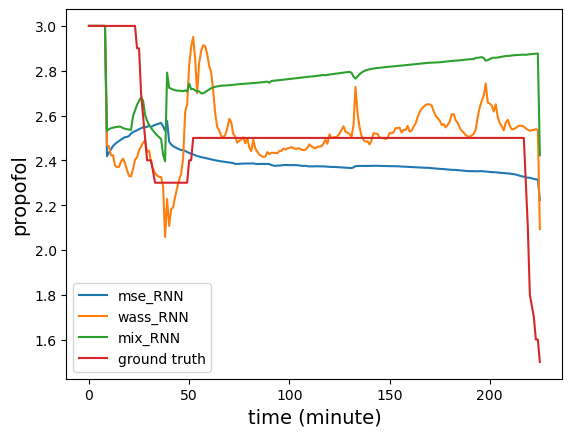

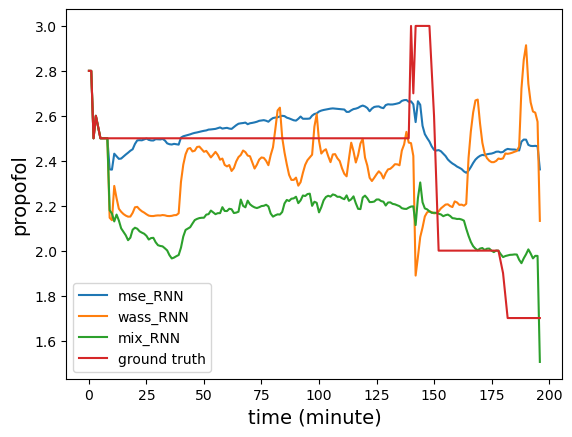

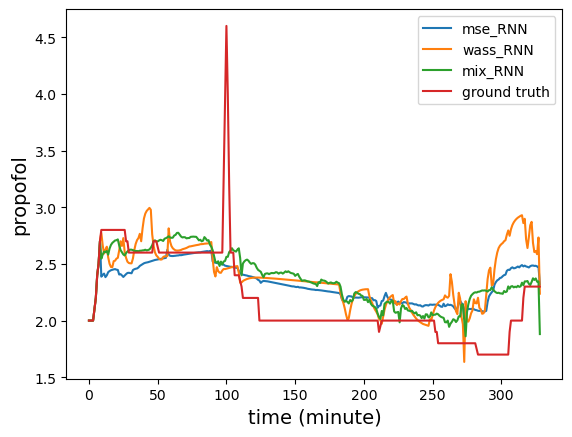

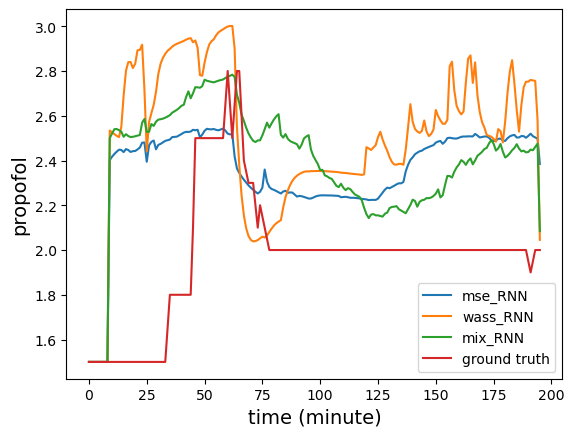

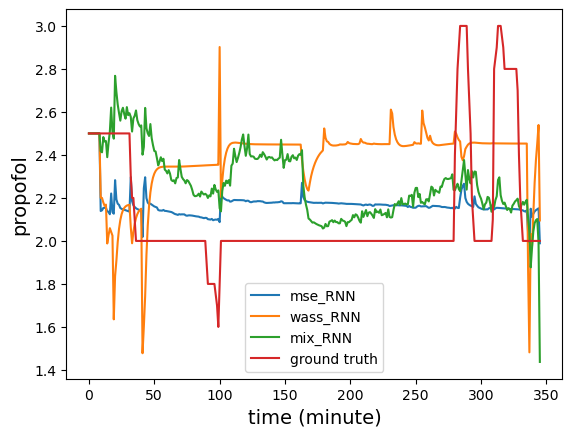

In [114]:
model_names = ['mse_RNN', 'wass_RNN', 'mix_RNN']

model = lstm(input_dim, hidden_dim, output_dim, unit_num, device).to(device)
for file_idx in range(605, 610):
    plt.figure()
    for model_name in model_names:
        model.load_state_dict(torch.load(f'model/{model_name}.pth'))
        x, y, l = X[file_idx].cuda(), Y[file_idx].cuda(), L[file_idx]
        y_pred = y[0].reshape(1, 1)
        pred_list = []
        model.hidden = model.init_hidden(1)

        for i in range(1, l+1):
            if i < gtn:
                y_pred = model(torch.cat([x[i].reshape(1, -1), y[i-1].reshape(1, 1)], 1))
                pred_list.append(y[i-1].reshape(1).cuda())
            else:
                y_pred = model(torch.cat([x[i].reshape(1, -1), y_pred.cuda()], 1))
                pred_list.append(y_pred[0].cuda())

        y = y[:l].cpu()
        y_pred = torch.cat(pred_list).cpu().detach().numpy()
        plt.plot(y_pred, label=model_name)
        
    plt.plot(y, label='ground truth')
    plt.xlabel('time (minute)', fontsize=14)
    plt.ylabel('propofol', fontsize=14)
    plt.legend()
    plt.show()